<a href="https://colab.research.google.com/github/VasundharaAgarwal/GANFingerprinting/blob/main/GAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import importlib

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import sys
sys.path.append('/content/gdrive/My Drive/')

In [5]:
import model_architectures as ma


In [ ]:
#learning rate for optimizers
lr = 0.0002
batch_size = 256
real_label = 1
fake_label = 0
num_epochs = 20
ngpu = 1
beta1 = 0.5
manualSeed = 500

torch.manual_seed(manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size = batch_size)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
criterion = nn.BCELoss()

#fixed noise used to visualize performance of GAN as it progresses through training
fixed_noise = torch.randn(64, ma.nz, 1, 1, device=device)

#establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.



In [ ]:
#slightly edited the code at https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def trainGAN(num, netG, netD):
  netG = netG.to(device)
  netD = netD.to(device)
  optimD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
  img_list = []
  D_x_list = []
  D_G_z1_list = []
  D_G_z2_list = []
  iters = 0
  for epoch in range(num_epochs):
      print(epoch)
      # For each batch in the dataloader
      for i, data in enumerate(train_loader, 0):

          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          ## Train with all-real batch
          netD.zero_grad()
          # Format batch
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          # Forward pass real batch through D
          output = netD(real_cpu).view(-1)
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          # Calculate gradients for D in backward pass
          errD_real.backward()
          D_x = output.mean().item()

          ## Train with all-fake batch
          # Generate batch of latent vectors
          noise = torch.randn(b_size, ma.nz, 1, 1, device=device)
          # Generate fake image batch with G
          fake = netG(noise)
          label.fill_(fake_label)
          # Classify all fake batch with D
          output = netD(fake.detach()).view(-1)
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, label)
          # Calculate the gradients for this batch
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # Add the gradients from the all-real and all-fake batches
          errD = errD_real + errD_fake
          # Update D
          optimD.step()

          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          netG.zero_grad()
          label.fill_(real_label)  # fake labels are real for generator cost
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake).view(-1)
          # Calculate G's loss based on this output
          errG = criterion(output, label)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimG.step()

          # Output training stats
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

          # Save Losses for plotting later
          D_x_list.append(D_x)
          D_G_z1_list.append(D_G_z1)
          D_G_z2_list.append(D_G_z2)
          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
              with torch.no_grad():
                  fake = netG(fixed_noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
          iters += 1

  torch.save({
            'G_state_dict': netG.state_dict(),
            'D_state_dict': netD.state_dict(),
            'optimG_state_dict': optimG.state_dict(),
            'optimD_state_dict': optimD.state_dict(),
            'img_list': img_list,
            'D_x_list': D_x_list,
            'D_G_z1_list' : D_G_z1_list,
            'D_G_z2_list' : D_G_z2_list,
            }, 'gdrive/My Drive/GANS/GAN_{}'.format(num))


In [ ]:
trainGAN(1, ma.Generator1(ngpu), ma.Discriminator1(ngpu))



0
[0/20][0/235]	Loss_D: 1.3809	Loss_G: 0.6942	D(x): 0.5125	D(G(z)): 0.5094 / 0.4996
[0/20][50/235]	Loss_D: 0.7326	Loss_G: 0.6963	D(x): 0.9591	D(G(z)): 0.4985 / 0.4984
[0/20][100/235]	Loss_D: 0.6934	Loss_G: 0.7026	D(x): 0.9906	D(G(z)): 0.4954 / 0.4953
[0/20][150/235]	Loss_D: 0.6826	Loss_G: 0.7084	D(x): 0.9956	D(G(z)): 0.4925 / 0.4924
[0/20][200/235]	Loss_D: 2.6008	Loss_G: 0.7005	D(x): 0.9651	D(G(z)): 0.9193 / 0.5014
1
[1/20][0/235]	Loss_D: 0.7170	Loss_G: 0.7188	D(x): 0.9543	D(G(z)): 0.4878 / 0.4875
[1/20][50/235]	Loss_D: 0.8566	Loss_G: 0.6456	D(x): 0.9609	D(G(z)): 0.5346 / 0.5328
[1/20][100/235]	Loss_D: 1.1351	Loss_G: 0.5692	D(x): 0.7932	D(G(z)): 0.5833 / 0.5714
[1/20][150/235]	Loss_D: 1.6787	Loss_G: 0.4365	D(x): 0.7054	D(G(z)): 0.7106 / 0.6538
[1/20][200/235]	Loss_D: 1.7186	Loss_G: 0.4607	D(x): 0.6549	D(G(z)): 0.7065 / 0.6412
2
[2/20][0/235]	Loss_D: 1.1615	Loss_G: 0.5994	D(x): 0.7397	D(G(z)): 0.5603 / 0.5571
[2/20][50/235]	Loss_D: 1.4045	Loss_G: 0.7127	D(x): 0.5036	D(G(z)): 0.5028 / 0.

In [ ]:
trainGAN(2,  ma.Generator2(ngpu), ma.Discriminator2(ngpu))

0
[0/20][0/235]	Loss_D: 1.3714	Loss_G: 0.7353	D(x): 0.5030	D(G(z)): 0.4952 / 0.4795
[0/20][50/235]	Loss_D: 0.7037	Loss_G: 0.6937	D(x): 0.9892	D(G(z)): 0.4998 / 0.4997
[0/20][100/235]	Loss_D: 0.6909	Loss_G: 0.6992	D(x): 0.9964	D(G(z)): 0.4970 / 0.4970
[0/20][150/235]	Loss_D: 0.7727	Loss_G: 0.6718	D(x): 0.9967	D(G(z)): 0.5211 / 0.5147
[0/20][200/235]	Loss_D: 1.4039	Loss_G: 0.5619	D(x): 0.5752	D(G(z)): 0.5638 / 0.5751
1
[1/20][0/235]	Loss_D: 1.1573	Loss_G: 0.7035	D(x): 0.6108	D(G(z)): 0.4822 / 0.4959
[1/20][50/235]	Loss_D: 1.3220	Loss_G: 0.6519	D(x): 0.5781	D(G(z)): 0.5311 / 0.5248
[1/20][100/235]	Loss_D: 1.3750	Loss_G: 0.6589	D(x): 0.5579	D(G(z)): 0.5409 / 0.5203
[1/20][150/235]	Loss_D: 1.3386	Loss_G: 0.6799	D(x): 0.5240	D(G(z)): 0.4909 / 0.5106
[1/20][200/235]	Loss_D: 1.3967	Loss_G: 0.5827	D(x): 0.5433	D(G(z)): 0.5406 / 0.5593
2
[2/20][0/235]	Loss_D: 1.3515	Loss_G: 0.7430	D(x): 0.5238	D(G(z)): 0.5024 / 0.4775
[2/20][50/235]	Loss_D: 1.3970	Loss_G: 0.6484	D(x): 0.5502	D(G(z)): 0.5474 / 0.

In [ ]:
manualSeed = 5405

torch.manual_seed(manualSeed)
random.seed(manualSeed)


trainGAN(3, ma.Generator3(ngpu), ma.Discriminator3(ngpu))

0
[0/20][0/235]	Loss_D: 1.4090	Loss_G: 0.7040	D(x): 0.4936	D(G(z)): 0.5048 / 0.4946
[0/20][50/235]	Loss_D: 0.7613	Loss_G: 1.5243	D(x): 0.6242	D(G(z)): 0.2489 / 0.2193
[0/20][100/235]	Loss_D: 0.7447	Loss_G: 0.7127	D(x): 0.9330	D(G(z)): 0.4904 / 0.4903
[0/20][150/235]	Loss_D: 0.7568	Loss_G: 0.6825	D(x): 0.9758	D(G(z)): 0.5104 / 0.5089
[0/20][200/235]	Loss_D: 1.7114	Loss_G: 0.5342	D(x): 0.5872	D(G(z)): 0.6512 / 0.6007
1
[1/20][0/235]	Loss_D: 1.3050	Loss_G: 0.6539	D(x): 0.5757	D(G(z)): 0.5222 / 0.5233
[1/20][50/235]	Loss_D: 1.4142	Loss_G: 0.6513	D(x): 0.5265	D(G(z)): 0.5288 / 0.5277
[1/20][100/235]	Loss_D: 1.3037	Loss_G: 0.6508	D(x): 0.5868	D(G(z)): 0.5334 / 0.5238
[1/20][150/235]	Loss_D: 1.3029	Loss_G: 0.6169	D(x): 0.5798	D(G(z)): 0.5282 / 0.5410
[1/20][200/235]	Loss_D: 1.3881	Loss_G: 0.5985	D(x): 0.5564	D(G(z)): 0.5475 / 0.5512
2
[2/20][0/235]	Loss_D: 1.3795	Loss_G: 0.6683	D(x): 0.5375	D(G(z)): 0.5293 / 0.5138
[2/20][50/235]	Loss_D: 1.4170	Loss_G: 0.5934	D(x): 0.5465	D(G(z)): 0.5545 / 0.

In [54]:
netG1 = ma.Generator1(0)
model_dict1 = torch.load('/content/gdrive/My Drive/GANS/GAN_1', map_location=torch.device('cpu'))
netG1.load_state_dict(model_dict1['G_state_dict'])


<All keys matched successfully>

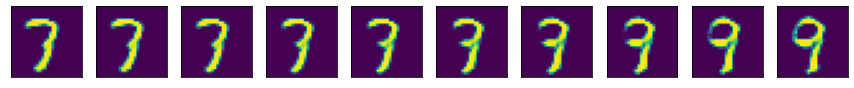

In [72]:
noise_1 = torch.randn(1,ma.nz, 1, 1)
noise_2 = torch.randn(1,ma.nz, 1, 1)
fig, ax = plt.subplots(1,10, figsize=(15,5))
i=0
for r in [x * 0.1 for x in range(0, 10)]:
  noise_temp = noise_1*r + noise_2*(1-r)
  img = netG1(noise_temp).detach().numpy().reshape(28,28)
  ax[i].imshow(img)
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  i=i+1

plt.show()

In [76]:
netG2 = ma.Generator2(0)
model_dict2 = torch.load('/content/gdrive/My Drive/GANS/GAN_2', map_location=torch.device('cpu'))
netG2.load_state_dict(model_dict2['G_state_dict'])


<All keys matched successfully>

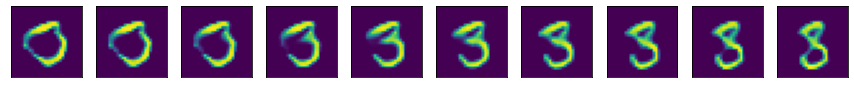

In [87]:
noise_1 = torch.randn(1,ma.nz, 1, 1)
noise_2 = torch.randn(1,ma.nz, 1, 1)
fig, ax = plt.subplots(1,10, figsize=(15,5))
i=0
for r in [x * 0.1 for x in range(0, 10)]:
  noise_temp = noise_1*r + noise_2*(1-r)
  img = netG2(noise_temp).detach().numpy().reshape(28,28)
  ax[i].imshow(img)
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  i=i+1

plt.show()

In [88]:
netG3 = ma.Generator3(0)
model_dict3 = torch.load('/content/gdrive/My Drive/GANS/GAN_3', map_location=torch.device('cpu'))
netG3.load_state_dict(model_dict3['G_state_dict'])

<All keys matched successfully>

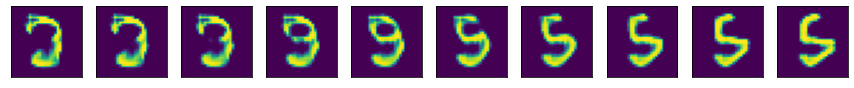

In [92]:
noise_1 = torch.randn(1,ma.nz, 1, 1)
noise_2 = torch.randn(1,ma.nz, 1, 1)
fig, ax = plt.subplots(1,10, figsize=(15,5))
i=0
for r in [x * 0.1 for x in range(0, 10)]:
  noise_temp = noise_1*r + noise_2*(1-r)
  img = netG3(noise_temp).detach().numpy().reshape(28,28)
  ax[i].imshow(img)
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  i=i+1

plt.show()